# Cox-Ingersoll-Ross (CIR) Model for Short Rate

## Import Libraries

The following libraries will be needed for this notebook.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.api as sm
import matplotlib.pyplot as plt

## Data Processing

The functions below help convert from years (`int`) to labels (`str`) and vice versa. 

- 1.0 = 1Y
- 0.5 = 6M
- 1.5 = 1Y6M

In [2]:
# Convert years to labels
def to_string(y):
    if y == 0:
        return ''
    elif y < 1:
        return f'{int(12*y)}M'
    else:
        return f'{int(y)}Y' + to_string(y%1)

# Convert labels to years
def to_year(s):
    y = 0
    if 'Y' in s:
        y += int(s[:s.find('Y')])
        s = s[s.find('Y')+1:]
    if 'M' in s:
        y += int(s[:s.find('M')]) / 12
    return y

The function below performs bootstraping to obtain zero rates.

In [3]:
# Performs bootstrapping to obtain zero rates
def bootstrap(df):
    N = 61
    interp = [np.nan for _ in range(N)]
    discount = [np.nan for _ in range(N)]
    zero_rate = [np.nan for _ in range(N)]

    for t in [0.5, 1, 2, 3, 5, 7, 10, 20, 30]:
        interp[int(t*2)] = df[to_string(t)]

    for t in range(1,N):
        # Interpolated Rates
        if np.isnan(interp[t]):
            dt = np.flatnonzero(~np.isnan(interp[t:]))[0]
            interp[t] = np.interp(t, [t-1,t+dt], [interp[t-1], interp[t+dt]])

        # Discount Factor
        if t <= 2:
            discount[t] = 1 / (1 + interp[t] / 100 * t/2)
        else:
            discount[t] = (1 - interp[t] / 100 * np.sum(discount[1:t]) * 0.5) / (1 + interp[t] / 100 * 0.5)
            
        # Zero-Rate
        zero_rate[t] = - 100 * np.log(discount[t]) / (t/2)
        
        # Modify entry
        if to_string(t/2) in df.index:
            df[to_string(t/2)] = zero_rate[t]
      
    # Convert the rest to continuous
    for t in [1/12, 2/12, 3/12]:
        df[to_string(t)] = 100 * np.log(1 + df[to_string(t)] / 100 * t) / t

    return df

The data used is the [US Treasury Par Yield Curves](https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value_month=202205). The data is first cleaned and the zero rates are obtained using bootstraping.

In [4]:
# Read csv
df = pd.read_csv('daily-treasury-rates.csv')

# Clean data
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Compute continuously compounded short rate and bootstrap zero-rates
df = df.apply(lambda df: bootstrap(df), axis=1)

df.head(10)

,Date,1M,2M,3M,6M,1Y,2Y,3Y,5Y,7Y,10Y,20Y,30Y
0,2018-01-02,1.289307,NaN,1.437414,1.603554,1.813457,1.912380,2.002932,2.248385,2.382577,2.464703,2.665469,2.887828
1,2018-01-03,1.289307,NaN,1.407521,1.583713,1.793815,1.932639,2.012938,2.248072,2.371744,2.443189,2.644487,2.852350
2,2018-01-04,1.279318,NaN,1.407521,1.593634,1.803636,1.952577,2.042973,2.267762,2.380913,2.463490,2.641126,2.864056
3,2018-01-05,1.269328,NaN,1.387590,1.573792,1.783992,1.952796,2.053258,2.288260,2.401280,2.472826,2.662650,2.885700
4,2018-01-08,1.299296,NaN,1.447378,1.593634,1.774168,1.952832,2.063417,2.288041,2.411714,2.494059,2.671606,2.880877
5,2018-01-09,1.269328,NaN,1.437414,1.593634,1.764344,1.972970,2.083467,2.328703,2.462823,2.555798,2.744791,2.954877
6,2018-01-10,1.309285,NaN,1.417485,1.583713,1.764344,1.972995,2.073349,2.318630,2.474012,2.555698,2.756655,2.952098
7,2018-01-11,1.319275,NaN,1.427450,1.573792,1.754518,1.973105,2.083563,2.318443,2.463244,2.545145,2.746279,2.999446
8,2018-01-12,1.309285,NaN,1.427450,1.583713,1.764344,1.983022,2.113759,2.348550,2.482706,2.553784,2.731788,2.913756
9,2018-01-16,1.329264,NaN,1.447378,1.623394,1.774168,2.022947,2.113055,2.358405,2.481972,2.542306,2.709058,2.891351


Afterwards, the data from January 2018 to March 2019 are selected. January 2018 to December 2018 is the in-sample data and January 2019 to March 2019 is the out-of-sample data. Additional regression variables are also calculated. These are explained below.

In [5]:
# Filter data from January 2018 to March 2019
df = df[(df['Date'] >= dt.datetime(2018,1,1)) & (df['Date'] < dt.datetime(2019,4,1))].reset_index(drop=True)

# Add regression columns
lag = 1
df['r'] = df['3M'] / 100
df['r_prev'] = df['r'].shift(lag)
df['dt'] = 1 / 260
df['x1'] = df['dt'] / np.sqrt(np.abs(df['r_prev']))
df['x2'] = - np.sqrt(np.abs(df['r_prev'])) * df['dt']
df['y'] = (df['r'] - df['r_prev']) / np.sqrt(np.abs(df['r_prev']))
df = df[df['y'].notna()].reset_index(drop=True)

df

,Date,1M,2M,3M,6M,1Y,2Y,3Y,5Y,7Y,10Y,20Y,30Y,r,r_prev,dt,x1,x2,y
0,2018-01-03,1.289307,NaN,1.407521,1.583713,1.793815,1.932639,2.012938,2.248072,2.371744,2.443189,2.644487,2.852350,0.014075,0.014374,0.003846,0.032080,-0.000461,-0.002493
1,2018-01-04,1.279318,NaN,1.407521,1.593634,1.803636,1.952577,2.042973,2.267762,2.380913,2.463490,2.641126,2.864056,0.014075,0.014075,0.003846,0.032419,-0.000456,0.000000
2,2018-01-05,1.269328,NaN,1.387590,1.573792,1.783992,1.952796,2.053258,2.288260,2.401280,2.472826,2.662650,2.885700,0.013876,0.014075,0.003846,0.032419,-0.000456,-0.001680
3,2018-01-08,1.299296,NaN,1.447378,1.593634,1.774168,1.952832,2.063417,2.288041,2.411714,2.494059,2.671606,2.880877,0.014474,0.013876,0.003846,0.032651,-0.000453,0.005076
4,2018-01-09,1.269328,NaN,1.437414,1.593634,1.764344,1.972970,2.083467,2.328703,2.462823,2.555798,2.744791,2.954877,0.014374,0.014474,0.003846,0.031969,-0.000463,-0.000828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,2019-03-25,2.467461,2.464930,2.452466,2.474627,2.381418,2.245285,2.175181,2.196841,2.312692,2.430147,2.715895,2.965666,0.024525,0.024525,0.003846,0.024560,-0.000602,0.000000
305,2019-03-26,2.457482,2.435052,2.452466,2.474627,2.410708,2.224986,2.165180,2.166390,2.282355,2.410750,2.707931,2.956942,0.024525,0.024525,0.003846,0.024560,-0.000602,0.000000
306,2019-03-27,2.447502,2.425092,2.432588,2.444994,2.371653,2.205447,2.145563,2.167192,2.272437,2.389921,2.663359,2.926763,0.024326,0.024525,0.003846,0.024560,-0.000602,-0.001269
307,2019-03-28,2.437523,2.445011,2.422649,2.425236,2.371653,2.215507,2.165666,2.187175,2.281891,2.388657,2.650751,2.900026,0.024226,0.024326,0.003846,0.024660,-0.000600,-0.000637


## Parameter Estimation

Following [Miao (2018)](http://urn.kb.se/resolve?urn=urn:nbn:se:lnu:diva-79154), in estimating the parameters $a$, $b$, and $\sigma$, the discrete version of the CIR model is considered. Suppose $t_i$ is the $i$ th trading day of the period $[0,T]$. Then, the short rate follows the process
\begin{align*}
    \Delta r_t &= a^* \left(b^*-r_t\right) \Delta t + \sigma \sqrt{|r_t|} \Delta W_t \\
    r_{t+1} - r_t &= a^* \left(b^*-r_t\right) \Delta t + \sigma \sqrt{|r_t|} \sqrt{\Delta t}~ \varepsilon \\
    \dfrac{r_{t+1} - r_t}{\sqrt{|r_t|}} &= \dfrac{a^* \left(b^*-r_t\right) \Delta t}{\sqrt{|r_t|}} + \sigma \sqrt{\Delta t}~ \varepsilon \\
    &= a^*b^* \dfrac{\Delta t}{\sqrt{|r_t|}} - a^* \sqrt{|r_t|} \Delta t + \sigma \sqrt{\Delta t}~ \varepsilon \\
    &= \beta_1 x_1 + \beta_2 x_2 + \epsilon,
\end{align*}
where $\varepsilon \sim N(0,1)$, $\beta_1 = a^* b^*$, $\beta_2 = a^*$, $x_1 = \dfrac{\Delta t}{\sqrt{|r_t|}}$, and $x_2 = - \sqrt{|r_t|} \Delta t$. In this form, it is apparent that the coefficients $a$, $b$, $\sigma$ can be obtained using linear regression, where $\sigma = \dfrac{\text{std error}}{\sqrt{\Delta t}}$. 

The cell below estimates the parameters $a$, $b$, and $\sigma$.

In [6]:
# Create in sample data frame
reg_df = df.copy()
reg_df = reg_df[reg_df['Date'] < dt.datetime(2019,1,1)].reset_index(drop=True)

# Perform linear regression
model = sm.OLS(endog=reg_df['y'], exog=reg_df[['x1', 'x2']]).fit()

# Get coeffcients
ab = model.params['x1']
a = model.params['x2']
b = ab / a
sigma = np.sqrt(model.scale) / np.sqrt(reg_df['dt'].mean())
gamma = np.sqrt(a**2 + 2*sigma**2)

print(ab, a, b, gamma, sigma, np.sqrt(model.scale))

0.028595007372181003 0.9190434577374313 0.03111387947048586 0.9196108792715653 0.02283957163179303 0.0014164501027403294


## Forecasting Short Rates & Term Structure

After obtaining the parameter values, the short rate can then be forecasted also using the discretized CIR model. Given $r_t$, the short rate tomorrow $r_{t+1}$ is obtained as
$$r_{t+1} = r_t + a^* \left(b^*-r_t\right) \Delta t + \sigma \sqrt{|r_t|} \sqrt{\Delta t}~ \varepsilon,$$
where $\varepsilon \sim N(0,1)$ is a randomly generated number from the standard normal distribution. 

The yield curve can then be obtained as 
\begin{align*}
    R(t,T) &= -\frac{1}{T-t} \ln P(t,T) \\
    &= -\frac{1}{T-t} \ln A(t,T) + \frac{1}{T-t} B(t,T) r_t,
\end{align*}
with 
$$B(t,T) = \frac{2\left(e^{\gamma(T-t)}-1\right)}{\left(\gamma +a)(e^{\gamma(T-t)}-1\right) + 2\gamma},$$
$$A(t,T) = \left[\frac{2\gamma e^{(a+\gamma)(T-t)/2}}{(\gamma +a)\left(e^{\gamma(T-t)} -1\right) + 2\gamma} \right]^{2ab/\sigma^2},$$
where $\gamma = \sqrt{a^2+2\sigma^2}$.

The cell below performs `N` simulations of the short rate and the yield curve and its average is obtained.

In [7]:
# Simulate N times
N = 1000
# Tenors to forecast
tenors = [1/12, 2/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30]
# New dataframe
pred_df = df.copy()

for s in range(N):
    # For each date i
    for i in pred_df.index:
        if s == 0:
            pred_df.loc[i, 'r_pred'] = 0
            for t in tenors:
                pred_df.loc[i, to_string(t)] = 0

        # If in-sample, skip
        if pred_df.loc[i,'Date'] < dt.datetime(2019,1,1):
            continue
        
        # Get previous r and forecast using discrete CIR
        r = pred_df.loc[i-lag, 'r']
        pred_df.loc[i, 'r'] = r + a * (b - r) * pred_df.loc[i, 'dt'] + sigma * np.sqrt(np.abs(r) * pred_df.loc[i, 'dt']) * np.random.randn()
        pred_df.loc[i, 'r_pred'] += 100 * pred_df.loc[i, 'r'] / N

        # Forecast yield curve
        for t in tenors:
            Bt = (2*(np.exp(gamma*t) - 1)) / ((gamma + a) * (np.exp(gamma*t) - 1) + 2*gamma) 
            At = ( (2*gamma * np.exp((a+gamma)*t/2)) / ((gamma+a) * (np.exp(gamma*t)-1) + 2*gamma) ) ** (2*a*b/sigma**2)
            Rt = - 1/t * np.log(At) + 1/t * Bt * pred_df.loc[i, 'r']
            pred_df.loc[i, to_string(t)] += 100 * Rt / N
            
pred_df = pred_df[pred_df['Date'] >= dt.datetime(2019,1,1)]

pred_df

,Date,1M,2M,3M,6M,1Y,2Y,3Y,5Y,7Y,10Y,20Y,30Y,r,r_prev,dt,x1,x2,y,r_pred
248,2019-01-02,2.469296,2.492962,2.515462,2.576598,2.675023,2.805963,2.884394,2.967094,3.007171,3.038039,3.074230,3.086296,0.024592,0.024425,0.003846,0.024610,-0.000601,-0.001908,2.444395
249,2019-01-03,2.472404,2.495955,2.518347,2.579186,2.677134,2.807440,2.885491,2.967789,3.007672,3.038391,3.074406,3.086413,0.024331,0.024127,0.003846,0.024761,-0.000597,-0.000640,2.447624
250,2019-01-04,2.474929,2.498387,2.520690,2.581289,2.678850,2.808640,2.886382,2.968354,3.008079,3.038676,3.074548,3.086508,0.024601,0.024028,0.003846,0.024813,-0.000596,0.000641,2.450247
251,2019-01-07,2.477447,2.500812,2.523027,2.583386,2.680560,2.809836,2.887270,2.968918,3.008485,3.038960,3.074690,3.086603,0.024907,0.024127,0.003846,0.024761,-0.000597,0.001920,2.452863
252,2019-01-08,2.479169,2.502471,2.524625,2.584820,2.681730,2.810654,2.887878,2.969303,3.008762,3.039155,3.074788,3.086668,0.025497,0.024425,0.003846,0.024610,-0.000601,0.000636,2.454652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,2019-03-25,2.582535,2.602026,2.620557,2.670905,2.751955,2.859768,2.924342,2.992427,3.025421,3.050834,3.080628,3.090561,0.025880,0.024525,0.003846,0.024560,-0.000602,0.000000,2.562026
305,2019-03-26,2.584209,2.603639,2.622111,2.672299,2.753092,2.860564,2.924933,2.992802,3.025691,3.051023,3.080722,3.090624,0.025915,0.024525,0.003846,0.024560,-0.000602,0.000000,2.563766
306,2019-03-27,2.584758,2.604167,2.622620,2.672756,2.753465,2.860825,2.925126,2.992924,3.025779,3.051085,3.080753,3.090645,0.025470,0.024525,0.003846,0.024560,-0.000602,-0.001269,2.564335
307,2019-03-28,2.587211,2.606530,2.624897,2.674799,2.755132,2.861990,2.925992,2.993473,3.026174,3.051362,3.080892,3.090737,0.025313,0.024326,0.003846,0.024660,-0.000600,-0.000637,2.566884


Afterwards, the forecasted yield curve, actual yield curve, and in-sample yield curve are plotted below. 

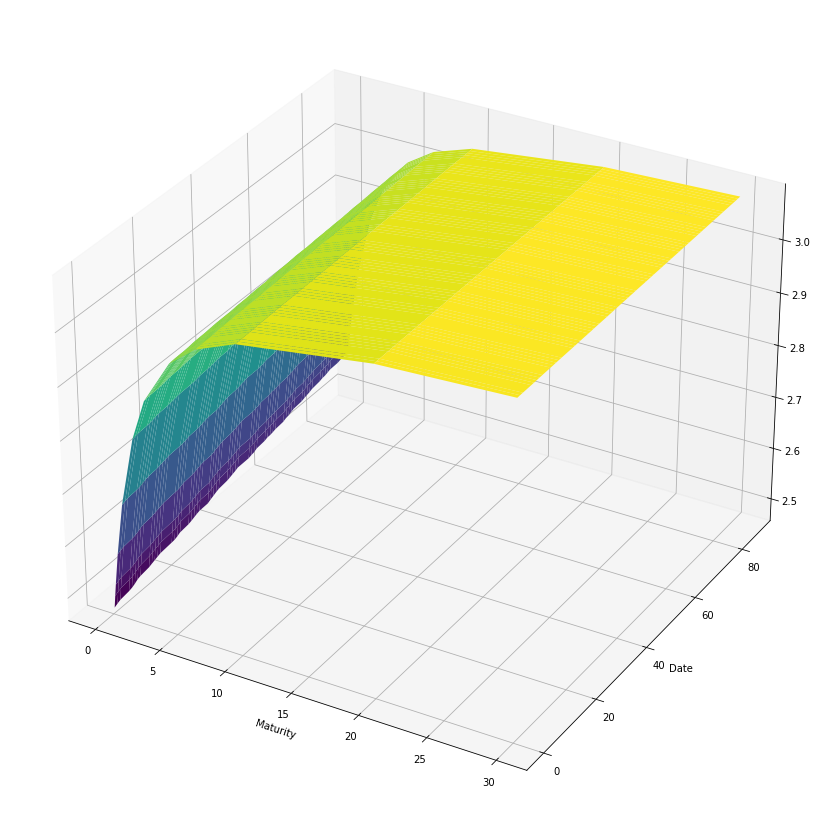

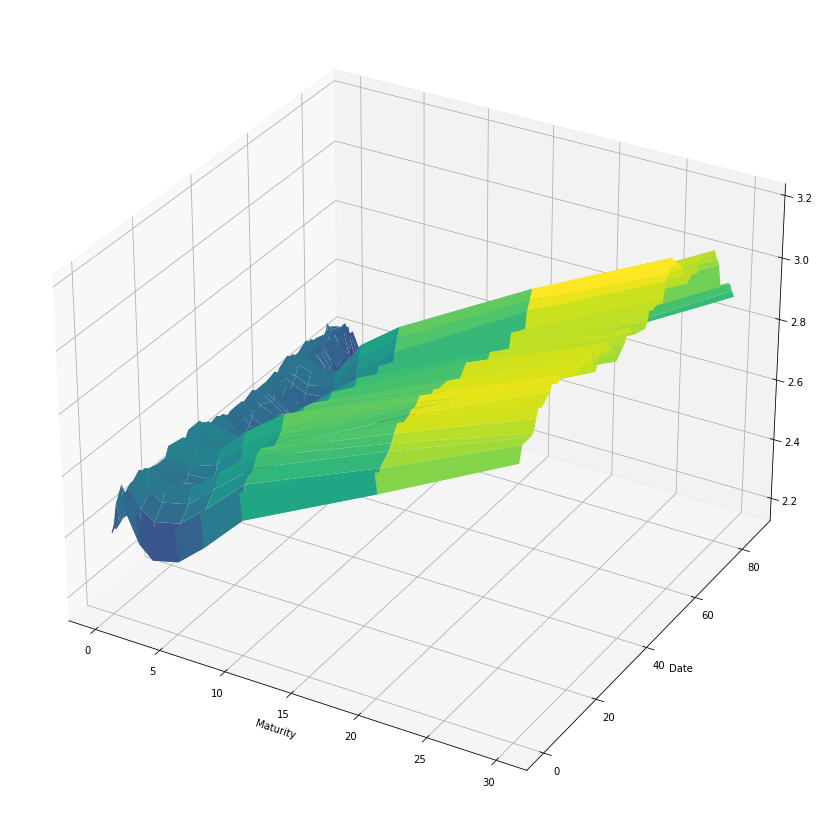

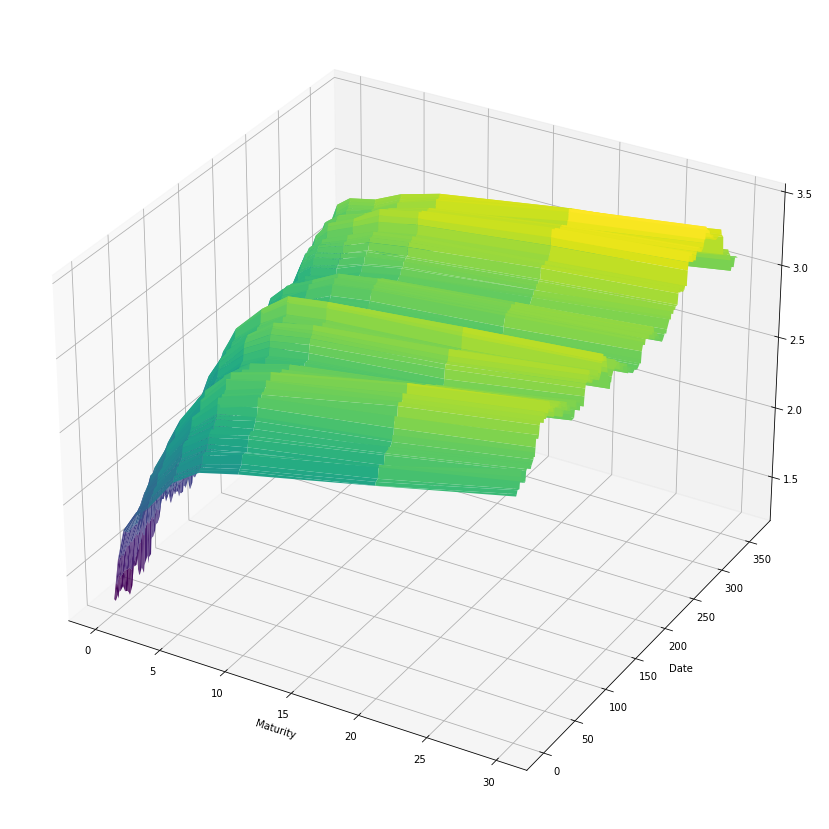

In [8]:
# Function to map values
def zero_rate(X,Y,df):
    Z = np.zeros(X.shape)
    for x in range(X.shape[0]):
        for y in range(X.shape[1]):
            Z[x][y] = df[df['Date'] == Y[x][y]][to_string(X[x][y])].iloc[0]
    return Z

# Function to plot surface
def plot_surf(df):
    # Meshgrid
    x = tenors
    y = df['Date']
    X, Y = np.meshgrid(x, y)
    Z = zero_rate(X,Y,df)

    # Change axes
    y = (df['Date'] - min(df['Date'])).dt.days
    X, Y = np.meshgrid(x, y)

    # Plot surface
    fig = plt.figure(figsize=(15, 15))
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    ax.set_xlabel('Maturity')
    ax.set_ylabel('Date')
    fig.show()

tenors = [1/12, 2/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30]
# Forecasted yield curve
plot_surf(pred_df[pred_df['Date'] >= dt.datetime(2019,1,1)])
# Actual yield curve
plot_surf(df[df['Date'] >= dt.datetime(2019,1,1)])

tenors = [1/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30] # NAN's error for 2/12
# In-sample yield curve
plot_surf(df[df['Date'] < dt.datetime(2019,1,1)])

A cross section of the yield curve at March 29, 2019 is also plotted below.

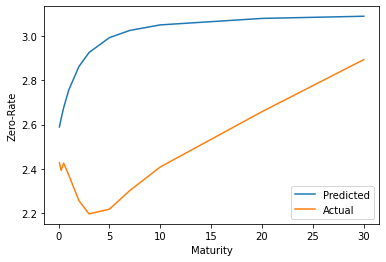

In [9]:
# Plot a cross section of yield curve
def cross(pred_df, df, date):
    pred_df = pred_df[pred_df['Date'] == date][['Date'] + [to_string(t) for t in tenors]].set_index('Date')
    df = df[df['Date'] == date][['Date'] + [to_string(t) for t in tenors]].set_index('Date')
    
    pred_df.columns = [to_year(col) for col in pred_df.columns]
    pred_df.index = ['Predicted']
    df.columns = [to_year(col) for col in df.columns]
    df.index = ['Actual']

    cross_df = pd.merge(pred_df.T, df.T, how='outer', left_index=True, right_index=True)
    plt.plot(cross_df)
    plt.xlabel('Maturity')
    plt.ylabel('Zero-Rate')
    plt.legend(('Predicted', 'Actual'))

cross(pred_df, df, dt.datetime(2019,3,29))

Finally, the short rates are plotted below.

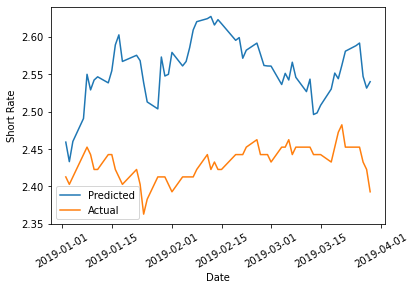

In [10]:
# Plot a time series of short rates
def short(pred_df, df):
    pred_df = pred_df[['Date', 'r']].rename({'r': 'Predicted'}, axis=1)
    df = df[['Date', 'r']].rename({'r': 'Actual'}, axis=1)
    
    short_df = pd.merge(pred_df, df, how='inner', on='Date').set_index('Date')
    short_df['Predicted'] *= 100
    short_df['Actual'] *= 100
    plt.plot(short_df)
    plt.xlabel('Date')
    plt.ylabel('Short Rate')
    plt.xticks(rotation = 30)
    plt.legend(('Predicted', 'Actual'))

short(pred_df, df)